## Overrinding the Tare Method

Last night I was recording tare (zero-weight readouts) values for the scale every second to make sure that it is relatively consistent across startups. I can't allow it to run the tare when it's time to feed because I can't assume that the scale is empty. So I plan to manually override the normal tare process for the scale.

## Plotting the Tares 2019-09-01

In [2]:
%matplotlib inline
import pandas
import statistics
import datetime
import dateutil
import matplotlib
# import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [20, 8]

In [3]:
matplotlib.rcParams['figure.figsize'] = [20, 8]

In [4]:
%%bash 
greadlink -f feeder_api/tare.csv

/Users/jp.jorissen/PycharmProjects/cat-feeder/feeder_api/tare.csv


In [5]:
df = pandas.read_csv('/Users/jp.jorissen/PycharmProjects/cat-feeder/feeder_api/tare.csv', names=['tares','junk'])

In retrospect, I regret not logging the timestamps. The below will be really close, though.

In [6]:
# stopped it around 7 AM
seven_am_this_morning = dateutil.parser.parse('2019-09-01 07:00 CST').timestamp()
# it ran once a minute until 7 AM
when_it_all_started = seven_am_this_morning - 60.2 * len(df['tares'])
timestamps = []
for i in range(len(df['tares'])):
    timestamps.append(when_it_all_started + i*60.2)

In [7]:
df = df[['tares']]
df['timestamps'] = timestamps
df['times'] = [datetime.datetime.fromtimestamp(ts) for ts in timestamps]

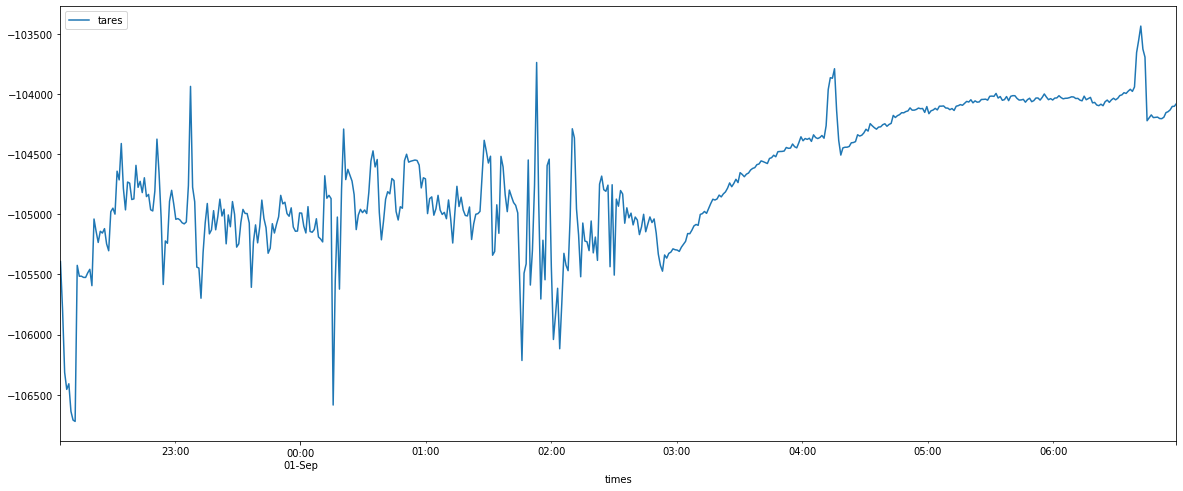

In [8]:
df.plot(x='times', y='tares')

## What's going on around 3AM? 

I went to bed around 3 AM, so this is what I think happened.

* I stopped typing and bumping the table that the scale is sitting on
* I stopped interacting with VSCode and the display eventually shut off, so VSCode probably stopped interacting so much with the remote SSH session to the pi, allowing the CPU and the pi to cool, which would reduce heat noise.

## Some basic stats

In [9]:
mean = statistics.mean(df['tares'])
stdev = statistics.stdev(df['tares'])
normalized = abs(stdev/ mean) * 100
print(mean, stdev, normalized)

-104707.86720867209 538.3659984526089 0.5141600271350198


In [10]:
%%html
<!--float my table to the left please-->
<style>
table {float:left}
</style>

The computed refernence unit for my scale was `gramRefUnit = 359` (the calculation went like the below)
```
# with just a container -> 34000 ish (never settled)
# continer with 1L of water in it -> 393000 ish (never settled)
# container + water - container = 393000 - 34000 = -> 1L of just water would display about 359000
# reference_unit = scale_output / weight_in_grams = 359000 / 1000 = 359
```

So the standard deviation is a little more than a gram. That's acceptable. For reference:

|Object|Scale Readout|Grams|
|------|-------------|-----|
|1L Water|359000|1000|
|Dish|65000|181|
|Food|9300|26|
|avg(tares)|104707|291|
|sdv(tares)|538|1.5|

So the standard deviation of these tares is about 5% of the actual food payload. And that is if we ignore how the right tail starting settling upward over time, increasing the standard deviation.

## Overriding the Tare

This is the code that the scale uses to get its current tare (zero-value).

```
def tare_A(self, times=15):
    # Backup REFERENCE_UNIT value
    backupReferenceUnit = self.get_reference_unit_A()
    self.set_reference_unit_A(1)

    value = self.read_average(times)

    if self.DEBUG_PRINTING:
        print("Tare A value:", value)

    self.set_offset_A(value)

    # Restore the reference unit, now that we've got our offset.
    self.set_reference_unit_A(backupReferenceUnit)

    return value
```

I am going to override ride that with the average (which will tend to cause overfeeding, I will compensate by slightly lowering the target weight).

```
def tare_A(self, times=15):
    # Backup REFERENCE_UNIT value
    backupReferenceUnit = self.get_reference_unit_A()
    self.set_reference_unit_A(1)
    
    # override
    value = -104707.9
    . . .
```